In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 시각적 미로 구현
matplot을 통해 미로를 만들어 줍니다.

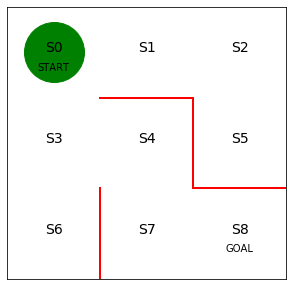

In [2]:
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

plt.plot([1, 1], [0, 1], color="red", linewidth=2)
plt.plot([1, 2], [2, 2], color="red", linewidth=2)
plt.plot([2, 2], [2, 1], color="red", linewidth=2)
plt.plot([2, 3], [1, 1], color="red", linewidth=2)

plt.text(0.5, 2.5, "S0", size=14, ha="center")
plt.text(1.5, 2.5, "S1", size=14, ha="center")
plt.text(2.5, 2.5, "S2", size=14, ha="center")
plt.text(0.5, 1.5, "S3", size=14, ha="center")
plt.text(1.5, 1.5, "S4", size=14, ha="center")
plt.text(2.5, 1.5, "S5", size=14, ha="center")
plt.text(0.5, 0.5, "S6", size=14, ha="center")
plt.text(1.5, 0.5, "S7", size=14, ha="center")
plt.text(2.5, 0.5, "S8", size=14, ha="center")
plt.text(0.5, 2.3, "START", ha="center")
plt.text(2.5, 0.3, "GOAL", ha="center")

ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

line, = ax.plot([0.5], [2.5], marker="o", color="g", markersize=60)

# 정책 반복 알고리즘

## 정책의 초기값 설정
에이전트의 정책을 결정하는 파라미터의 초기값인 theta_0을 설정해줍니다.  
각 줄은 state 0~7 각각 취할 수 있는 행동들을 의미합니다.  
행동은 각각 상, 우, 하, 좌에 해당됩니다.

In [3]:
theta_0 = np.array([[np.nan, 1, 1, np.nan],      # s0
                    [np.nan, 1, np.nan, 1],      # s1
                    [np.nan, np.nan, 1, 1],      # s2
                    [1, 1, 1, np.nan],           # s3
                    [np.nan, np.nan, 1, 1],      # s4
                    [1, np.nan, np.nan, np.nan], # s5
                    [1, np.nan, np.nan, np.nan], # s6
                    [1, 1, np.nan, np.nan],      # s7
                    # s8은 목표 지점이기에 정책 x
                   ])

np.set_printoptions(precision=3, suppress=True)

## 초기 정책 정의
파라미터 theta를 기반으로 정책을 계산합니다.

### 단순 비율 계산
이 계산 과정은 각 행동이 똑같은 확률을 가지도록 합니다.

In [4]:
def simple_convert_into_pi_from_theta(theta):
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        
    pi = np.nan_to_num(pi)
    
    return pi

### 소프트맥스 함수 계산
변화하는 파라미터가 음수가 되는 경우에도 정책을 계산할 수 있도록 항상 양수의 값을 내놓는 지수 함수로 정책 함수를 만들어 줍니다.  
$$ P(\theta_i)=\frac{exp(\beta \theta_i)}{exp(\beta \theta_1)+exp(\beta \theta_2)+\cdots} $$  
$$ = \frac{exp(\beta \theta_i)}{\sum_{j=1}^{N_a}exp(\beta \theta_j)} $$  
$\beta$는 행동이 무작위로 선택되는 정도를 의미한다. 작을수록 더욱 무작위로 선택된다.

In [5]:
def softmax_convert_into_pi_from_theta(theta):
    beta = 1.0
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    
    exp_theta = np.exp(beta * theta)
    
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        
    pi = np.nan_to_num(pi)
    
    return pi        

### 초기 정책 가져오기
정의한 함수를 통해 에이전트를 움직일 초기 정책을 구합니다.

In [6]:
# pi_0 = simple_convert_into_pi_from_theta(theta_0)
pi_0 = softmax_convert_into_pi_from_theta(theta_0)

pi_0

array([[0.   , 0.5  , 0.5  , 0.   ],
       [0.   , 0.5  , 0.   , 0.5  ],
       [0.   , 0.   , 0.5  , 0.5  ],
       [0.333, 0.333, 0.333, 0.   ],
       [0.   , 0.   , 0.5  , 0.5  ],
       [1.   , 0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.5  , 0.5  , 0.   , 0.   ]])

## 이동과 도착 함수 정의
에이전트가 한 단계 이동하여 상태를 바꿀 수 있도록 함수를 만듭니다.  
이 함수를 반복하여 도착 지점에 도달했는지 판단하는 함수도 만들어 줍니다.

### 상태 기록
이동 함수가 다음 상태를 반환함으로써 도착 함수에서 이동 함수를 반복하는 동안
에이전트가 어디로 이동했는지 기록하도록 합니다.

In [7]:
# def get_next_s(pi, s):
#     direction = ["up", "right", "down", "left"]
    
#     next_direction = np.random.choice(direction, p=pi[s, :])
    
#     if next_direction == "up":
#         s_next = s - 3
#     elif next_direction == "right":
#         s_next = s + 1
#     elif next_direction == "down":
#         s_next = s + 3
#     elif next_direction == "left":
#         s_next = s - 1
        
#     return s_next

# def goal_maze(pi):
#     s = 0
#     state_history = [0]
    
#     while True:
#         next_s = get_next_s(pi, s)
#         state_history.append(next_s)
        
#         if next_s == 8:
#             break
#         else:
#             s = next_s
            
#     return state_history

### 상태와 액션 기록
이동 함수가 다음 상태뿐만 아니라 그 상태로 가기 위한 액션 또한 반환함으로써
에이전트가 취한 행동과 그 행동으로 인해 어떤 상태로 변했는지 기록됩니다.

In [8]:
def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    
    next_direction = np.random.choice(direction, p=pi[s, :])
    
    if next_direction == "up":
        action = 0
        s_next = s - 3
    elif next_direction == "right":
        action = 1
        s_next = s + 1
    elif next_direction == "down":
        action = 2
        s_next = s + 3
    elif next_direction == "left":
        action = 3
        s_next = s - 1
        
    return [action, s_next]

def goal_maze_ret_s_a(pi):
    s = 0
    s_a_history = [{'state':0, 'action':np.nan}]
    
    while (1):
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1]['action'] = action
        
        s_a_history.append({'state':next_s, 'action':np.nan})
        
        if next_s == 8:
            break
        else:
            s = next_s
            
    return s_a_history

### 초기 정책의 결과
초기 정책으로 에이전트를 움직였을 때, 상태와 행동의 기록을 출력한다.

In [9]:
# state_history = goal_maze(pi_0)

# print(state_history)
# print("목표 지점에 이르기까지 걸린 단계 수 :", len(state_history)-1)

In [10]:
# state_history = goal_maze(pi_0)

# print(state_history)
# print("목표 지점에 이르기까지 걸린 단계 수 :", len(state_history)-1)

s_a_history = goal_maze_ret_s_a(pi_0)

for h in s_a_history:
    print([h['state'], h['action']], end=', ')
print()
    
print("목표 지점에 이르기까지 걸린 단계 수 :", len(s_a_history)-1)

[0, 1], [1, 1], [2, 2], [5, 0], [2, 3], [1, 1], [2, 2], [5, 0], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 1], [2, 2], [5, 0], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 1], [2, 3], [1, 3], [0, 2], [3, 0], [0, 1], [1, 3], [0, 2], [3, 1], [4, 2], [7, 0], [4, 3], [3, 2], [6, 0], [3, 0], [0, 1], [1, 3], [0, 2], [3, 0], [0, 2], [3, 0], [0, 1], [1, 1], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 1], [4, 3], [3, 0], [0, 2], [3, 2], [6, 0], [3, 1], [4, 2], [7, 1], [8, nan], 
목표 지점에 이르기까지 걸린 단계 수 : 68


## 정책 수정
Policy Gradient 알고리즘으로 파라미터를 수정한다.  
$$ \theta_{s_i, a_j}=\theta_{s_i, a_j}+\eta \cdot \Delta \theta_{s, a_j} $$  
$$ \Delta \theta_{s, a_j} = \{N(s_i, a_j)-P(s_i, a_j)N(s_i, a)\}/T $$
$\eta$는 학습률로, 한 학습에 얼마나 수정되냐를 결정한다. 작을 수록 학습 속도가 늦어지고, 너무 높으면 오버피팅 된다.

In [11]:
def update_theta(theta, pi, s_a_history):
    eta = 0.1
    T = len(s_a_history)-1
    
    [m, n] = theta.shape
    delta_theta = theta.copy()
    
    for i in range(0, m):
        for j in range(0, n):
            if not np.isnan(theta[i, j]):
                SA_i = [SA for SA in s_a_history if SA['state'] == i]
                SA_ij = [SA for SA in SA_i if SA['action'] == j]
                
                if not SA_ij == [SA for SA in s_a_history if SA == {'state':i, 'action':j}]:
                    raise Exception("not equal error")
                
                N_i = len(SA_i)
                N_ij = len(SA_ij)
                
                delta_theta[i, j] = (N_ij - pi[i, j] * N_i) / T
            
    new_theta = theta + eta*delta_theta
    
    return new_theta

## 정책 반복 알고리즘

In [12]:
# stop_epsilon = 10**-3 * 5

# theta = theta_0
# pi = pi_0

# is_continue = True
# count = 1

# P = []

# while is_continue:
#     P.append(pi)
    
#     s_a_history = goal_maze_ret_s_a(pi)
#     new_theta = update_theta(theta, pi, s_a_history)
#     new_pi = softmax_convert_into_pi_from_theta(new_theta)
    
#     print(np.sum(np.abs(new_pi - pi)))
#     print("목표 지점에 이르기까지 걸린 단계 수:", len(s_a_history)-1)
    
#     if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
#         is_continue = False
#     else:
#         theta = new_theta
#         pi = new_pi

## 정책 반복 알고리즘의 결과

In [13]:
# print(pi)
# s_a_history = goal_maze_ret_s_a(pi)

# 가치 반복

## 가치 함수 무작위 정의
가치 반복 알고리즘에서 사용할 가치 함수 Q를 정의해준다.  
초기값은 무작위로 정해준다.

In [14]:
[a, b] = theta_0.shape
Q = np.random.rand(a, b) * theta_0 * 0.1
print(Q)

[[  nan 0.041 0.095   nan]
 [  nan 0.044   nan 0.05 ]
 [  nan   nan 0.053 0.024]
 [0.049 0.044 0.075   nan]
 [  nan   nan 0.02  0.049]
 [0.05    nan   nan   nan]
 [0.      nan   nan   nan]
 [0.055 0.055   nan   nan]]


## 무작위 정책 정의

In [15]:
pi_0 = simple_convert_into_pi_from_theta(theta_0)

## $\epsilon$-greedy 알고리즘 구현

In [16]:
def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    if np.random.rand() < epsilon:
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        next_direction = direction[np.nanargmax(Q[s, :])]
                
    action = direction.index(next_direction)
        
    return action

def get_s_next(s, a, Q, epsilon):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]
    
    if next_direction == "up":
        s_next = s - 3
    elif next_direction == "right":
        s_next = s + 1
    elif next_direction == "down":
        s_next = s + 3
    elif next_direction == "left":
        s_next = s - 1
        
    return s_next

### Sarsa 알고리즘 구현
벨만 방정식에 기초하여 TD 오차를 바탕으로 행동가치 함수 Q를 수정하는 알고리즘을 만들어준다.

In [17]:
def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta*(r-Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta*(r + gamma*Q[s_next, a_next] - Q[s, a])
        
    return Q

### Q-learning 알고리즘 구현

In [18]:
def Q_learning(s, a, r, s_next, a_next, Q, eta, gamma):
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta*(r-Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta*(r + gamma*np.nanmax(Q[s_next, :]) - Q[s, a])
        
    return Q

## 도착 함수 구현

In [19]:
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi, update_func):
    s = 0
    a = a_next = get_action(s, Q, epsilon, pi)
    s_a_history = [{'state':0, 'action':np.nan}]
    
    while True:
        a = a_next
        
        s_a_history[-1]['action'] = a
        
        s_next = get_s_next(s, a, Q, epsilon)
        
        s_a_history.append({'state':s_next, 'action':np.nan})
        
        if s_next == 8:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            
        Q = update_func(s, a, r, s_next, a_next, Q, eta, gamma)
        
        if s_next == 8:
            break
        else:
            s = s_next
            
    return [s_a_history, Q]

## 가치 반복 알고리즘

In [20]:
eta = 0.1
gamma = 0.9
epsilon = 0.5
v = np.nanmax(Q, axis=1)
print(v)
is_continue = True
episode = 1

V = []
V.append(v)

while is_continue:
    print("에피소드:", episode)
    
    epsilon = epsilon / 2
    
#     [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0, update_func=Sarsa)
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0, update_func=Q_learning)
    
    new_v = np.nanmax(Q, axis=1)
    print(np.sum(np.abs(new_v - v)))
    v = new_v
    V.append(v)
    
    print("목표 지점에 이르기까지 걸린 단계 수:", len(s_a_history)-1)
    
    episode = episode + 1
    if episode > 100:
        break

[0.095 0.05  0.053 0.075 0.049 0.05  0.    0.055]
에피소드: 1
0.2796449371438784
목표 지점에 이르기까지 걸린 단계 수: 376
에피소드: 2
0.09403540311878206
목표 지점에 이르기까지 걸린 단계 수: 44
에피소드: 3
0.10044139501946181
목표 지점에 이르기까지 걸린 단계 수: 56
에피소드: 4
0.09433278781409465
목표 지점에 이르기까지 걸린 단계 수: 12
에피소드: 5
0.09282845925664235
목표 지점에 이르기까지 걸린 단계 수: 8
에피소드: 6
0.09094572667751485
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 7
0.09002074435570287
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 8
0.08906336318159508
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 9
0.08806076747631836
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 10
0.08700181712030569
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 11
0.08587736836394833
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 12
0.08468042028302776
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 13
0.08340613195171026
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 14
0.08205174638728249
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 15
0.08061644987062783
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 16
0.0791011891155596
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 17
0.07750846373656221
목표 지점에 이르기까지 걸린 단계 수: 4
에피소드: 18
0.07584210736805898
목표 지점에 이르기까지 걸린 단계 수: 4
에피

## 가치 반복 알고리즘의 결과

In [21]:
print(Q)

[[  nan 0.032 0.724   nan]
 [  nan 0.032   nan 0.032]
 [  nan   nan 0.031 0.032]
 [0.033 0.809 0.033   nan]
 [  nan   nan 0.9   0.034]
 [0.031   nan   nan   nan]
 [0.03    nan   nan   nan]
 [0.055 1.      nan   nan]]


# 애니메이션 시각화
에이전트의 이동 과정을 애니메이션으로 만듭니다.

In [22]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm
from tqdm import tqdm

def init():
    line.set_data([], [])
    return (line,)

def animate_history(i):
    state = s_a_history[i]['state']
    x = (state % 3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line, )

anim_history = animation.FuncAnimation(fig, animate_history, init_func=init, frames=len(s_a_history), interval=100, repeat=False)

HTML(anim_history.to_jshtml())

In [23]:
def animate_episode_policy(i):
    CENTER = np.array([[0.5, 2.5], [1.5, 2.5], [2.5, 2.5], [0.5, 1.5], [1.5, 1.5], [2.5, 1.5], [0.5, 0.5], [1.5, 0.5], [2.5, 0.5]])
    point = np.array([[-0.5, 0.5], [0.5, 0.5], [0.5, -0.5], [-0.5, -0.5], [-0.5, 0.5]])
    for state_n in range(len(P[i])):
        C = np.tile(CENTER[state_n], (2, 1))
        for p in range(len(P[i][state_n])):
            XY = C + point[p:p+2, :]
            XY = np.append(XY, CENTER[state_n].reshape(-1,2), axis=0)
            triangle = plt.Polygon(XY, color=cm.jet(P[i][state_n][p]))
            ax.add_patch(triangle)

def animate_episode_value(i):
    line, = ax.plot([0.5], [2.5], marker="s", color=cm.jet(V[i][0]), markersize=85)
    line, = ax.plot([1.5], [2.5], marker="s", color=cm.jet(V[i][1]), markersize=85)
    line, = ax.plot([2.5], [2.5], marker="s", color=cm.jet(V[i][2]), markersize=85)
    line, = ax.plot([0.5], [1.5], marker="s", color=cm.jet(V[i][3]), markersize=85)
    line, = ax.plot([1.5], [1.5], marker="s", color=cm.jet(V[i][4]), markersize=85)
    line, = ax.plot([2.5], [1.5], marker="s", color=cm.jet(V[i][5]), markersize=85)
    line, = ax.plot([0.5], [0.5], marker="s", color=cm.jet(V[i][6]), markersize=85)
    line, = ax.plot([1.5], [0.5], marker="s", color=cm.jet(V[i][7]), markersize=85)
    line, = ax.plot([2.5], [0.5], marker="s", color=cm.jet(1.0), markersize=85)
    return (line, )

# anim_episode = animation.FuncAnimation(fig, animate_episode_policy, init_func=init, frames=tqdm(range(len(P))), interval=100, repeat=False)
anim_episode = animation.FuncAnimation(fig, animate_episode_value, init_func=init, frames=len(V), interval=100, repeat=False)

HTML(anim_episode.to_jshtml())